<center><h1>Introduction </h1></center>

> <b>Competition Setting: </b>Predicting Future Sales for a Russian software retail company 1C; Given a timeseries starting 2013-2015 Oct for sales of 1C on various items in it's multiple shop outlets, the ask is to predict monthly sales for the various shop-item pairs in Nov 2015.<br>
> <b>Why is this interesting for 1C: </b>This is a crucial question to start any data analytics process with; One of the biggest benefits data science delivers to retail companies is optimizing their inventory and procurement.
Thanks to predictive tools, businesses can use historical data and trend analysis to determine which products they should order-> they can optimize inventory management to emphasize products customers need effectively.

<center><h1>Dataset </h1></center>

Let me begin by giving a flavor of the beast we are dealing with here, the very voluminous but relatively easily comprehensible datasets we are to work with-;

> <b>sales_train.csv - </b>the training set. Daily historical data from January 2013 to October 2015.<br>
> <b>test.csv - </b>the test set. We need to forecast the sales for these shops and products for November 2015.<br>
> <b>items.csv - </b>supplemental information about the items/products (item names)<br>
> <b>item_categories.csv - </b>supplemental information about the items categories (item category names)<br>
> <b>shops.csv - </b>supplemental information about the shops (shop names)<br>

<b>Key Data Challenges - </b>Aside from the common issues of outliers and missing data (as we will see, the data quality provided here is actually very good, so we don't have to worry about these issues very much), there are 3 unique (or maybe not actually) data challenges-;

> <b>Russian Data - </b>Nearly all of the data is in Russian text, however we as data explorer junkies are not to be deterred by this! Here I will show how we can easily translate all of the text to English and the amazing insights this will lead us to, just as all the breathtaking stories only data hows to tell.<br>
> <b>Large Data - </b>The sales_train dataframe comprises of 3 million rows, which obfuscates signal detection to some extent but also obviously provides us with a tremendous opportunity to get more data insights and to pull our big guns out and brag with our more complex data forecasting processes. However for achieving this, we must endeavour to trim the noise from the data as far as possible.<br>
> <b>Mix of shops and items Data (with some Test data items unseen in Train) - </b>We are presented with transactions of various items and various shops in our train data set. Our model must be versatile enough so that it can build a wholesome model that can find ways to consistently predict despite these variations. Moreover it must be able to predict for items for which we have no data in our train set too!

<center><h1>Motivation </h1></center>

> I very recently embarked on this exciting data science expedition and ever since I have wondered why did I not delve into this intricate world before. This kernel (as part of a 2 kernels series) is intended to showcase (and most importantly to brag, of course) how much I enjoyed working on this data challenge (I am <b>currently placed 12/11789 place (top 0.1%) with 0.821 RMSE score</b>) and the unbelievably massive learning I had (will talk more about my learnings in the 2nd kernel); but it is also my hope that I can reveal some really exciting and breathtaking insights about this seemingly run-of-the-mill sales data, so that the reader is engaged and exhilarated enough to want to venture on working on this data themselves too and join in on the data adventures here!<br><br>
> As is custom, I began working with EDA, in order to invoke ideas for feature engineering, which as we know, is one of the most (if not THE most) significant processes for achieving good forecasting accuracy - here I have presented a snapshot of some of the most beautiful data visualizations which led me to some very unique feature engineering ideas and the final forecasting score that I achieved. Wondrously, this dataset offered the opportunity to leverage a huge variety of feature engineering tools- I have displayed here the many features I developed- <b>geolocation, text vectorization,log transformations,discretization of continuos features and target mean encodings of categorical features</b>.<br>

<center><h1><b>Importing Libraries..</b></h1></center>

In [ ]:
!pip install translate
!pip install folium
!pip install geopy
!pip install yellowbrick
!pip install google_trans_new

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from google_trans_new import google_translator

from geopy.geocoders import Nominatim
import folium

from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 
from operator import itemgetter

#sns.set(font_scale = 2)

In [2]:
os.chdir("C:/Users/PC/Desktop/Programming/Kaggle/1C_Sales")
sales=pd.read_csv("Inputs/sales_train.csv")
index_cols = ['shop_id', 'item_id', 'date_block_num']

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


>This is the primary dataframe we will work with, as aforementioned the item,item category and shop names can all be derived from the other supplemental dataframes, and we will get to that soon enough...Let us first examine the distributions of the two numeric features given to us, the item price and item count day (target).

In [4]:
sales['item_cnt_day'].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

>First observation to make here is that there are negative entries for our target variable here as well, and this is because this represents the items returned. It is a viable option to try to treat these by suitably getting rid of them, however I am actually going to opt to leave them as is since <b>are looking to forecast monthly sales, not daily sales, so when we aggregate these daily sales to monthly (to have a uniform time frame as the test dataset),</b>these should automatically be squared off against the original sales. We will do a check at that point, to make sure this happens as we expect it to, of course.<br><br>
>We also see the mean>median, so we know this distribution is skewed to the right, perhaps a log transformation would be nice to run here. Let us also visualize the distribution with a violin (yes you read that right).

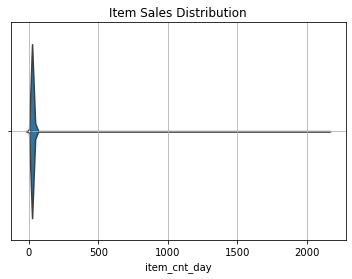

In [23]:
#histogram
sns.violinplot(sales['item_cnt_day'],split=True)
plt.title("Item Sales Distribution")
plt.grid()

In [15]:
sales['item_cnt_day'].value_counts(bins=3)

(-24.192, 708.333]     2935847
(708.333, 1438.667]          1
(1438.667, 2169.0]           1
Name: item_cnt_day, dtype: int64

>Most values are concentrated until ~400. 2 of the values are really extreme->we can be reasonably confident that they are outliers and would not help the forecasts in any way. I mean sales of >700 in a single transaction of an item by a software retail company seems super unlikely.Let's get rid of them.

In [3]:
sales = sales[sales['item_cnt_day'] <= 700]

In [17]:
sales['item_cnt_day'].value_counts(bins=2)

(-22.692, 323.5]    2935828
(323.5, 669.0]           19
Name: item_cnt_day, dtype: int64

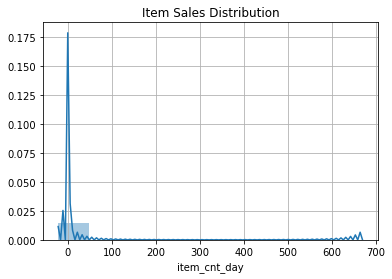

In [20]:
sns.distplot(sales['item_cnt_day'],kde=True,bins=10)
plt.title("Item Sales Distribution")
plt.grid()

>As we can see from the value counts and plot above, the distribution looks a bit more reasonable after removing the outliers.

In [21]:
print("Skewness: %f" % sales['item_cnt_day'].skew())
print("Kurtosis: %f" % sales['item_cnt_day'].kurt())

Skewness: 100.053652
Kurtosis: 20154.135729


>The skewness and kurtosis are clearly too high, using a log transformation here is a good idea. Let us see if this is the case with our other numeric feature too.

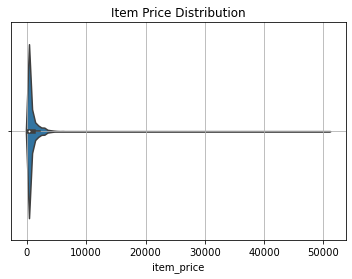

In [35]:
sns.violinplot(sales['item_price'])
plt.title("Item Price Distribution")
plt.grid()

In [28]:
sales['item_price'].value_counts(bins=6)

(-308.98199999999997, 51329.167]    2935847
(51329.167, 102659.333]                   1
(256649.833, 307980.0]                    1
(102659.333, 153989.5]                    0
(153989.5, 205319.667]                    0
(205319.667, 256649.833]                  0
Name: item_price, dtype: int64

>As we can see above, the same problems seem to plague item price as well. But unlike item sales, here there is no reason for us to have negative item prices (I say this but I remember the last time I was shifting apartments, I <b>paid</b> a fortune so that somebody would buy and take away that worn-out sofa from me! True story). Let us get rid of the negative and extremely high values. 

In [4]:
sales = sales[(sales['item_price'] > 0) & (sales['item_price'] < 51000)]

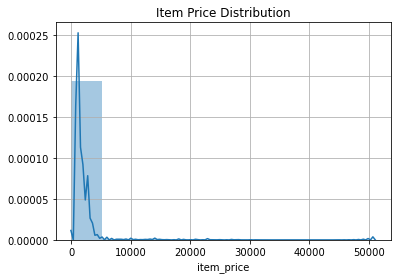

In [36]:
sns.distplot(sales['item_price'],kde=True,bins=10)
plt.title("Item Price Distribution")
plt.grid()

In [110]:
print("Skewness: %f" % sales['item_price'].skew())
print("Kurtosis: %f" % sales['item_price'].kurt())

Skewness: 8.981222
Kurtosis: 109.247253


>There, the distribution plot is much more reasonable now, however once again we see a significant skew. Again using a log transformation is a good idea when we prepare the data for training our models.All these fancy data distributions, why can't they just be <b>normal</b>?
>
>Let us now look at how these 2 numeric features have developed over time. But since I am going to be aggregating the data in a monthly time frame (this is the one we are most interested in); instead of plotting item price, I am going to use a factor of item price and sales count, 'Revenue'.

In [5]:
sales['Revenue']=sales['item_cnt_day']*sales['item_price']

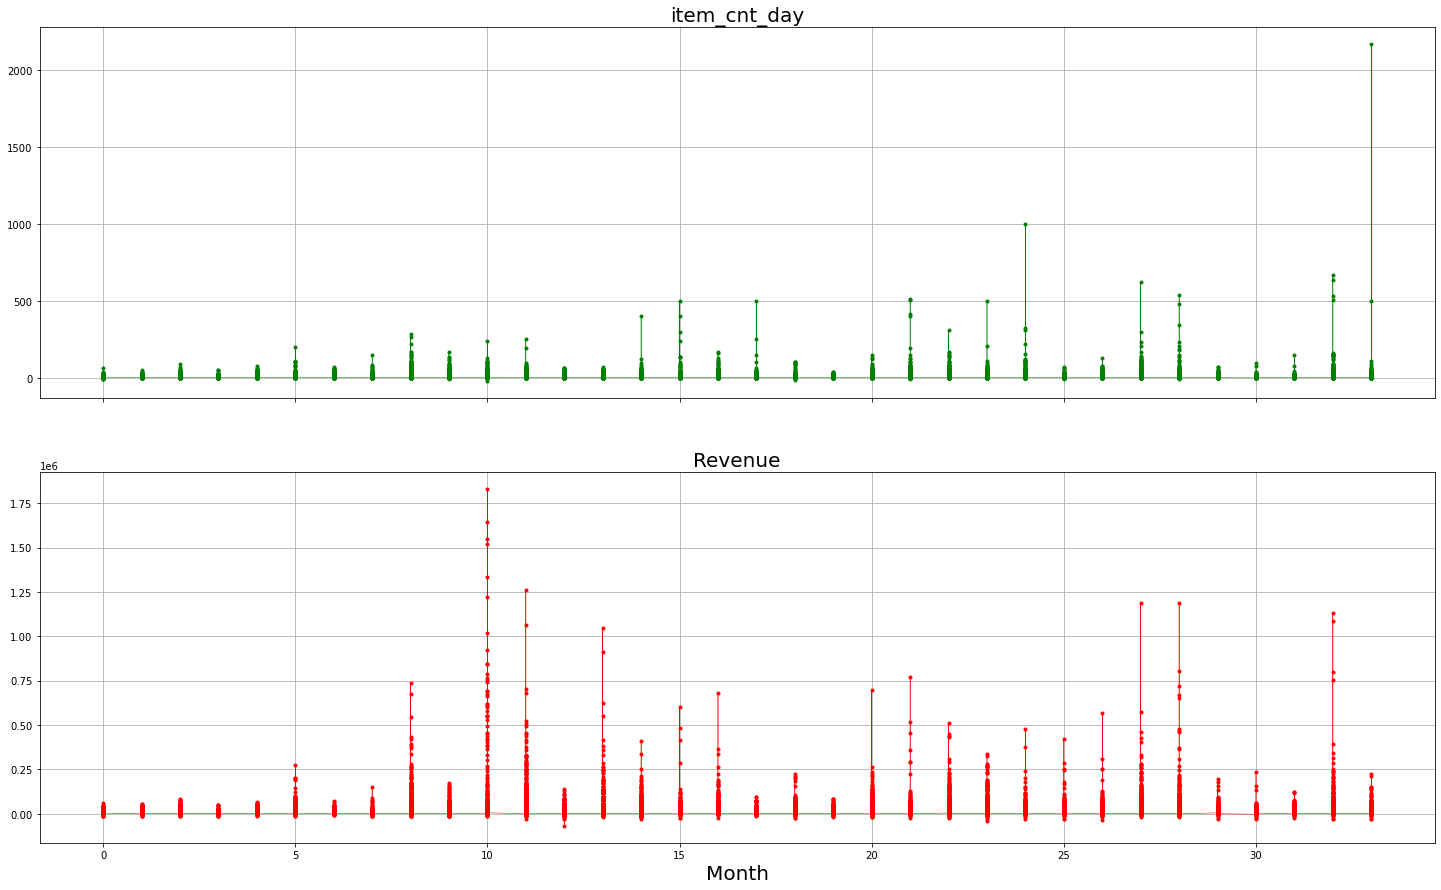

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True)
colors={'item_cnt_day':'green','Revenue':'red'}
for name, ax in zip(['item_cnt_day','Revenue'], axes):
    ax.plot(sales.set_index('date_block_num')[name], marker='.', linestyle='-', linewidth = 0.5, label=name, color=colors[name])
    #sns.boxplot(data = sales, x='date_block_num', y=name, ax=ax)
    ax.set_ylabel("",fontsize=20)
    ax.set_xlabel("Month",fontsize=20)
    ax.set_title(name,fontsize=20)
    ax.grid()
    if ax != axes[-1]:
        ax.set_xlabel('')

>As for the trends that we can observe for the 2 timeseries plots, we see a general increase in item sales and Revenue over time. The advantage of having the luxury of being able to create both the plots sharing the X-axis, thanks again to Matplotlib, is that we can see a very interesting trend of negative correlation between Revenue and item sales, obviously item price and item sales seem to exhibit some comovement; which is intuitive as well- bigger bulk of products are generally sold at lower prices and vice versa.
>
>Also we can clearly observe a tinge of seasonality, indicating an need for taking this into account while training our models. I will do so by creating a very simple 'month' feature, so that each transaction is linked to the month of that transaction. 

In [6]:
sales['month']=sales['date_block_num']%12+1
sales['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

>Finally let us do a spot check for any missing data in our dataframe.

In [12]:
sales.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
Revenue           0
month             0
dtype: int64

>Like I said earlier, our data is actually extremely clean,now let's move towards analyzing some of the supplemental datasets. That's where I promise our analysis will get so much more creative and amazing!

In [7]:
shops=pd.read_csv("Inputs/shops.csv")
sales=sales.join(shops.set_index('shop_id'),on='shop_id',how='left')

In [10]:
sales['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)',
       'Москва ТК "Буденовский" (пав.А2)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "Новый век" (Новокосино)',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       '!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Жуковский ул. Чкалова 39м?',
       'Казань ТЦ "ПаркХаус" II', 'Казань ТЦ "Бехетле"',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Серебряный Дом"', 'Н.Новгород ТРЦ "Фантастика"',
       '

>After merging the shops dataset to our main dataframe, we see that all names are in Russian, so unless we have all native speakers here, we must translate it all to extract some interesting features from the shop names.

In [8]:
translator = google_translator()
import time

shop_translations = {}
unique_elements = shops['shop_name'].unique()
for element in unique_elements:
    # add translation to the dictionary
    
    shop_translations[element] = translator.translate(element)

shops['Trans_shops']=shops['shop_name'].map(shop_translations)
sales['Trans_shops']=sales['shop_name'].map(shop_translations)

In [16]:
sales['Trans_shops'].unique()

array(['Yaroslavl shopping center "Altair" ', 'Moscow TRK "Atrium" ',
       'Moscow TK "Budenovsky" (Pav.K7) ',
       'Moscow TK "Budenovsky" (Pav.A2) ',
       'Kursk shopping center "Pushkinsky" ', 'Moscow Shop C21 ',
       'Krasnoyarsk TC "June" ', 'Moscow MTRC "AFI MALL" ',
       'Moscow TC "Mega Teply Stan" II ',
       'Moscow TC "Mega White Dacha II" ',
       'Moscow shopping center "New Century" (Novokosino) ',
       'Moscow TC "Area" (Belyaevo) ',
       'Volzhsky shopping center "Volga Mall" ',
       'Voronezh (Plekhanovskaya, 13) ', 'Adygea shopping center "Mega" ',
       'Balashiha TRK "October-Kinomir" ', 'Voronezh Trec "Maximir" ',
       '! Yakutsk Ordzhonikidze, 56 fran ',
       '! Yakutsk shopping center "Central" Fran ', 'Kolo TC "RIO" ',
       'Kaluga TPC "XXI Century" ', 'Voronež TRC City Park "Town" ',
       'Zhukovsky st. Chkalova 39m? ',
       'Kazan shopping center "Parkhouse" II ', 'Kazan TC "BEHETLE" ',
       'Online store emergency ', 'Ufa TC "Fa

>There, isn't that so much better, finally we see something that we can use. Already we can make a significant observation here; the 'Yakutsk' shop, seems to be really similar in name. After doing some comprehensive checking of all the shop names, I could find 4 shops that are very identically named-;

In [17]:
print(sales.loc[sales['shop_id']==0,'Trans_shops'].iloc[0],sales.loc[sales['shop_id']==57,'Trans_shops'].iloc[0])
print(sales.loc[sales['shop_id']==1,'Trans_shops'].iloc[0],sales.loc[sales['shop_id']==58,'Trans_shops'].iloc[0])
print(sales.loc[sales['shop_id']==11,'Trans_shops'].iloc[0],sales.loc[sales['shop_id']==10,'Trans_shops'].iloc[0])
print(sales.loc[sales['shop_id']==40,'Trans_shops'].iloc[0],sales.loc[sales['shop_id']==39,'Trans_shops'].iloc[0])

! Yakutsk Ordzhonikidze, 56 fran  Yakutsk Ordzhonikidze, 56 
! Yakutsk shopping center "Central" Fran  Yakutsk shopping center "Central" 
Zhukovsky st. Chkalova 39m²  Zhukovsky st. Chkalova 39m? 
Rostovnadon TRK "Megcenter Horizon" island  Rostnone TRK "Megacentr Horizont" 


In [9]:
print(sales.loc[sales['shop_id']==0,'shop_name'].iloc[0],sales.loc[sales['shop_id']==57,'shop_name'].iloc[0])
print(sales.loc[sales['shop_id']==1,'shop_name'].iloc[0],sales.loc[sales['shop_id']==58,'shop_name'].iloc[0])
print(sales.loc[sales['shop_id']==11,'shop_name'].iloc[0],sales.loc[sales['shop_id']==10,'shop_name'].iloc[0])
print(sales.loc[sales['shop_id']==40,'shop_name'].iloc[0],sales.loc[sales['shop_id']==39,'shop_name'].iloc[0])

!Якутск Орджоникидзе, 56 фран Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м² Жуковский ул. Чкалова 39м?
РостовНаДону ТРК "Мегацентр Горизонт" Островной РостовНаДону ТРК "Мегацентр Горизонт"


>As we can see from both the English and original Russian shop names (yayyy I can read Russian now too!), this almost certainly is an error, the names are near identical and is probably a data entry typo. But just to be double sure let us examine the time periods these shops are present in to check if they are interspersed.

In [20]:
print(str(sales.loc[sales['shop_id']==0,'date_block_num'].unique()),str(sales.loc[sales['shop_id']==57,'date_block_num'].unique()))
print(str(sales.loc[sales['shop_id']==1,'date_block_num'].unique()),str(sales.loc[sales['shop_id']==58,'date_block_num'].unique()))
print(str(sales.loc[sales['shop_id']==11,'date_block_num'].unique()),str(sales.loc[sales['shop_id']==10,'date_block_num'].unique()))
print(str(sales.loc[sales['shop_id']==40,'date_block_num'].unique()),str(sales.loc[sales['shop_id']==39,'date_block_num'].unique()))

[0 1] [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33]
[0 1] [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33]
[25] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30 31 32 33]
[14 15 16 17 18 19 20 21 22 23 24] [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


>Just as I suspected, the time periods these shops are present in are mutually exclusive (shop nos. 40 and 39 do have some common periods but even for them in the last 10 months, there is only data for shop 39), further strengthening my suspicion. Damn, I would make a good detective, wouldn't you agree? But then again all data scientists like you would too.
>
>Let us set these shops to be the same, so that their data can be accurately aggregated and the shop sales are not misrepresented. I am going to set these shops to be equal to the ones which are in the Test Set, for ease in training and then forecasting.

In [9]:
sales.loc[sales['shop_id']==0,'shop_name']=sales.loc[sales['shop_id']==57,'shop_name'].iloc[0]
sales.loc[sales['shop_name']==sales.loc[sales['shop_id']==57,'shop_name'].iloc[0],'shop_id']=57
sales.loc[sales['shop_id']==1,'shop_name']=sales.loc[sales['shop_id']==58,'shop_name'].iloc[0]
sales.loc[sales['shop_name']==sales.loc[sales['shop_id']==58,'shop_name'].iloc[0],'shop_id']=58
sales.loc[sales['shop_id']==11,'shop_name']=sales.loc[sales['shop_id']==10,'shop_name'].iloc[0]
sales.loc[sales['shop_name']==sales.loc[sales['shop_id']==10,'shop_name'].iloc[0],'shop_id']=10
sales.loc[sales['shop_id']==40,'shop_name']=sales.loc[sales['shop_id']==39,'shop_name'].iloc[0]
sales.loc[sales['shop_name']==sales.loc[sales['shop_id']==39,'shop_name'].iloc[0],'shop_id']=39

In [22]:
sales['shop_id'].nunique()

56

>With that completed, our shops count has dropped and we can be more confident about the data in the context of shops. Now we can suitably scruitinize the shop wise data to make some inferences on the same, let's begin by checking which shops have the highest amount of transactions, and how skewed this distribution is, but this let's add some color to our plots, shall we?

Text(0.5, 1.0, 'High Frequency shop_ids')

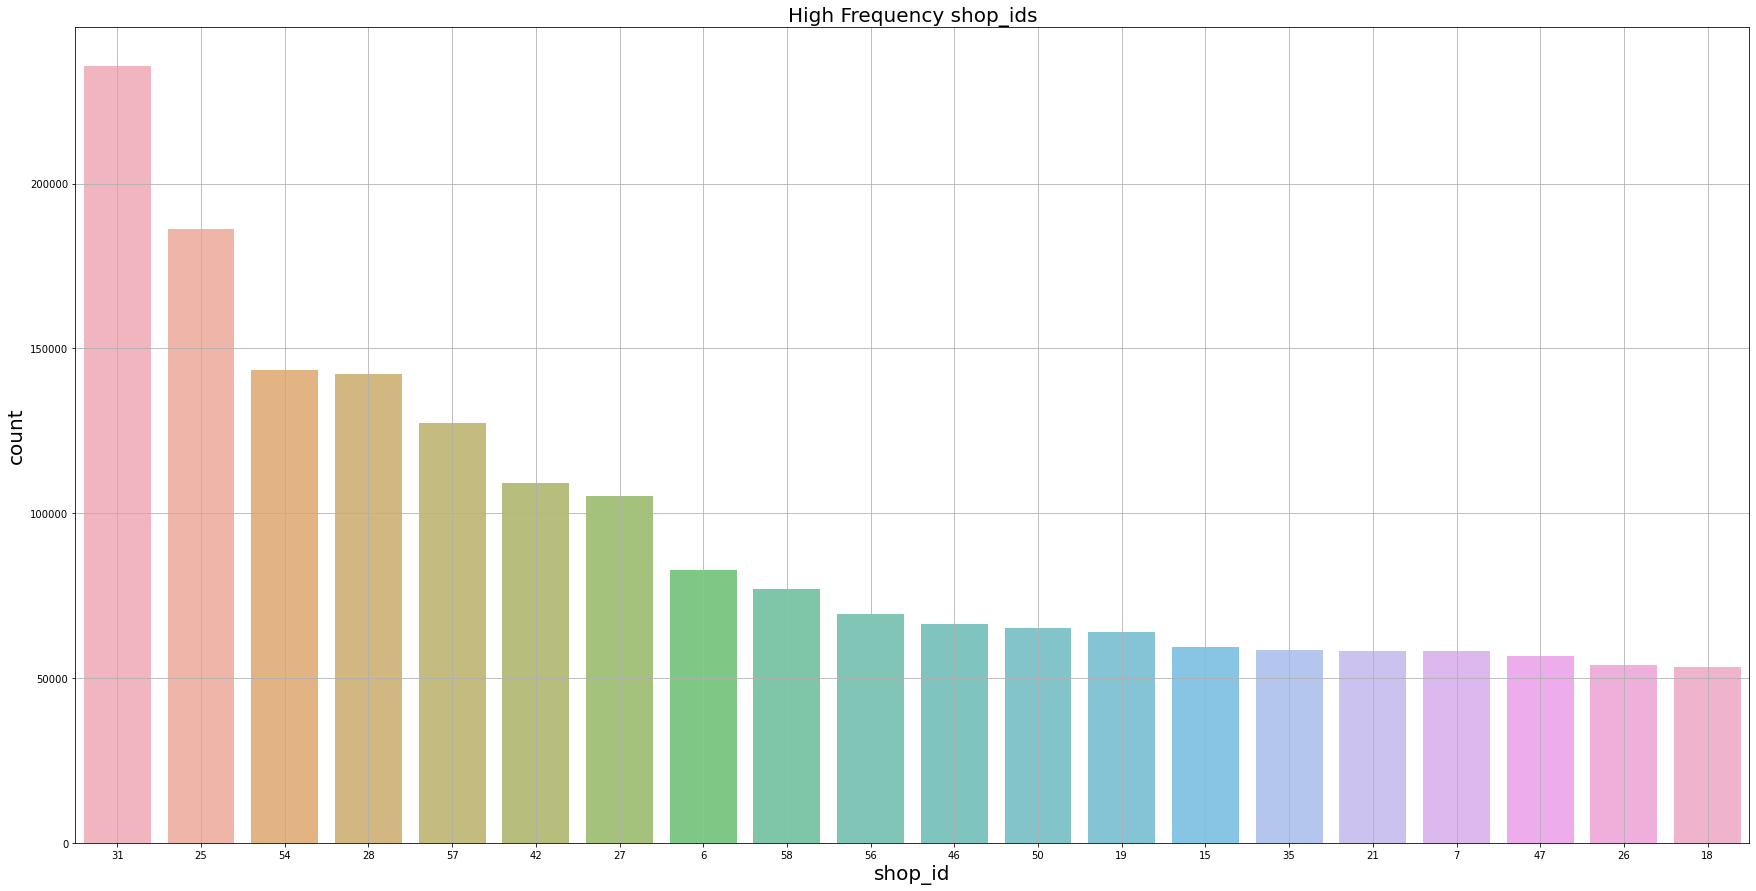

In [23]:
fig, ax = plt.subplots(1,1, figsize=(30, 15))
sns.countplot('shop_id', data= sales,
                 order=sales['shop_id'].value_counts().index[:20],
                 alpha=0.7)
#ax[i//3][i%3].set_ylim([0, 250000])
ax.set_xlabel("shop_id",fontsize=20)
ax.set_ylabel("count",fontsize=20)
ax.grid()
ax.set_title('High Frequency shop_ids', fontsize=20)

>Obviously not all shops have the same number of transactions, with some shops winning the bulk of the transactions. However the important question we must ask ourselves is does the highest number of transactions translate to highest number of item sales (our target variable, after all)? 

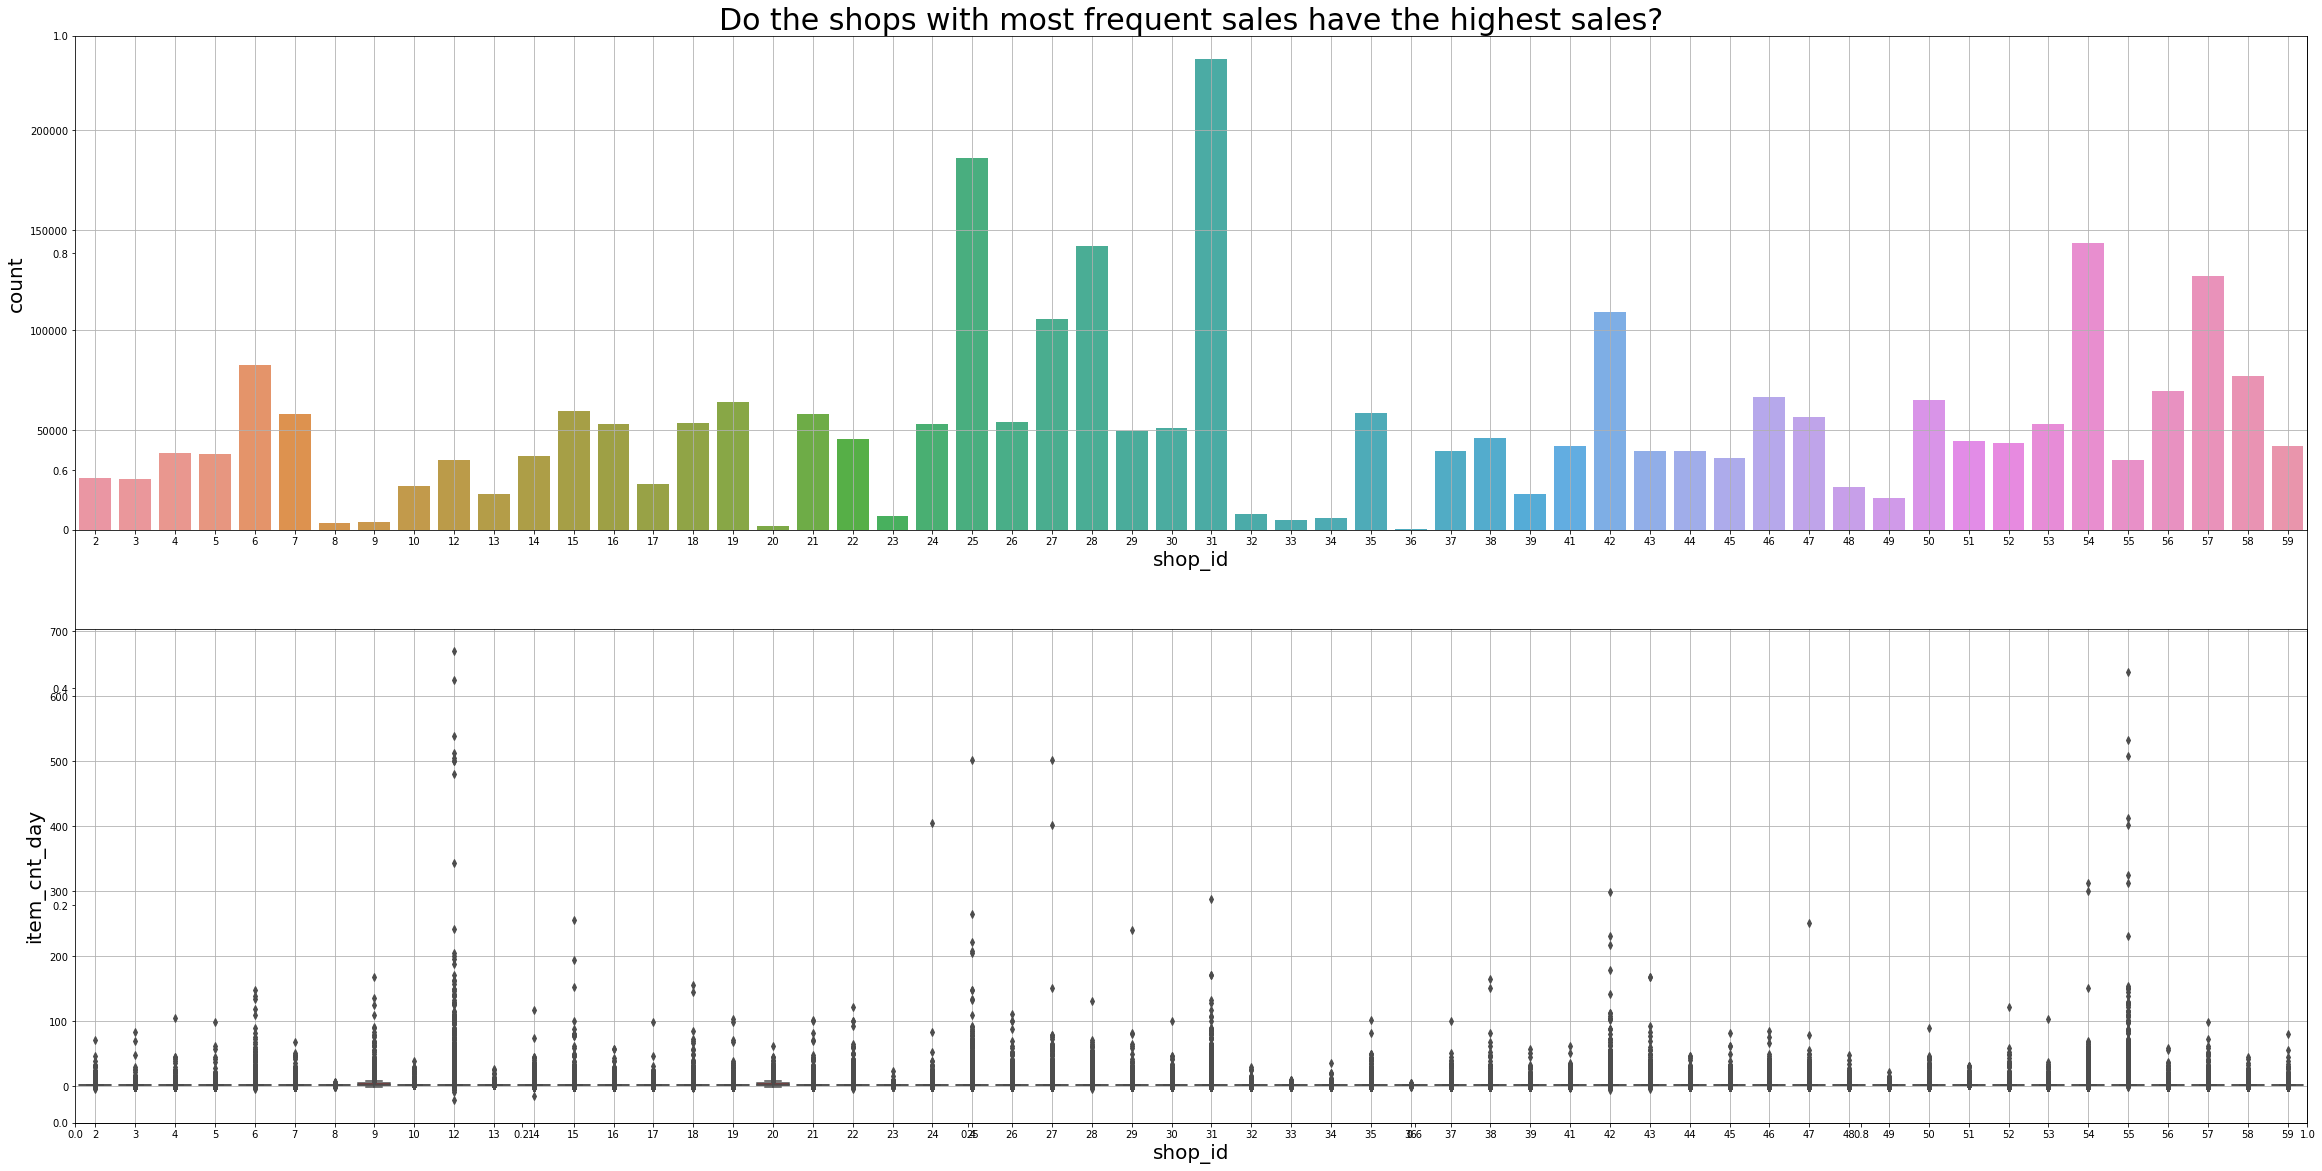

In [29]:
fig = plt.figure(figsize=(40, 20))

plt.title("Do the shops with most frequent sales have the highest sales?",fontsize=30)

ax1 = fig.add_subplot(2,1,1)
sns.countplot(data = sales, x = 'shop_id', ax = ax1)
ax1.set_xlabel("shop_id",fontsize=20)
ax1.set_ylabel("count",fontsize=20)
ax1.grid()

ax2 = fig.add_subplot(2,1,2)
sns.boxplot(data = sales, x='shop_id', y='item_cnt_day' , ax = ax2)
ax2.set_xlabel("shop_id",fontsize=20)
ax2.set_ylabel("item_cnt_day",fontsize=20)
ax2.grid()

>Suprise, suprise! The number of transactions seems to be inversely related (loosely speaking) to the number of total item sales by the shops. This is a useful discovery, because going forward (in my 2nd kernel), I use the number of transactions per month for each shop as a feature, and it definitely has significance.
>
>An important challenge of our dataset as I mentioned before is that we are presented with transactions for a large amount of shops, are all of these shops present in our test set? Let us investigate.

In [10]:
test=pd.read_csv("Inputs/test.csv")
print("We have a total of "+str(test['shop_id'].nunique())+" shops in our test set.")

We have a total of 42 shops in our test set.


>So only 42 of the 56 shops of our train set are present in the test set. This begs a very pivotal question, especially given the already large amount of train data, whether should we really retain the data for those 14 shops absent in the test set? Would they really add value to our forecasting process for the test set? Even if they do add some value, do they justify the vast amount of baggage (large data) they carry?
>
>These are some very tricky questions to approach, and as usual the answer lies within our data itself. Let us try to primarily examine for 2 traits within the shops data-;
>
> - How much value do these extra 14 shops add to the forecasting of the rest of the 42 shops test data. We need to find a way to quantify this, or even better, visualize it.
> - How much noise do these 14 shops have in their data?

In [11]:
shopwise_sales=pd.DataFrame(sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum()).reset_index()

In [12]:
shopwise_sales['month_item']=shopwise_sales['date_block_num'].astype('str')+'_'+shopwise_sales['item_id'].astype('str')
del shopwise_sales['date_block_num'],shopwise_sales['item_id']

In [13]:
shopwise_sales=shopwise_sales.set_index('month_item').pivot(columns='shop_id',values='item_cnt_day').fillna(0.0)
shopwise_sales.shape

(233911, 56)

>Finally now that our pivoted shopwise dataset is ready in the format I like, I have the license to get the first big weapon out of my Seaborn arsenal! 

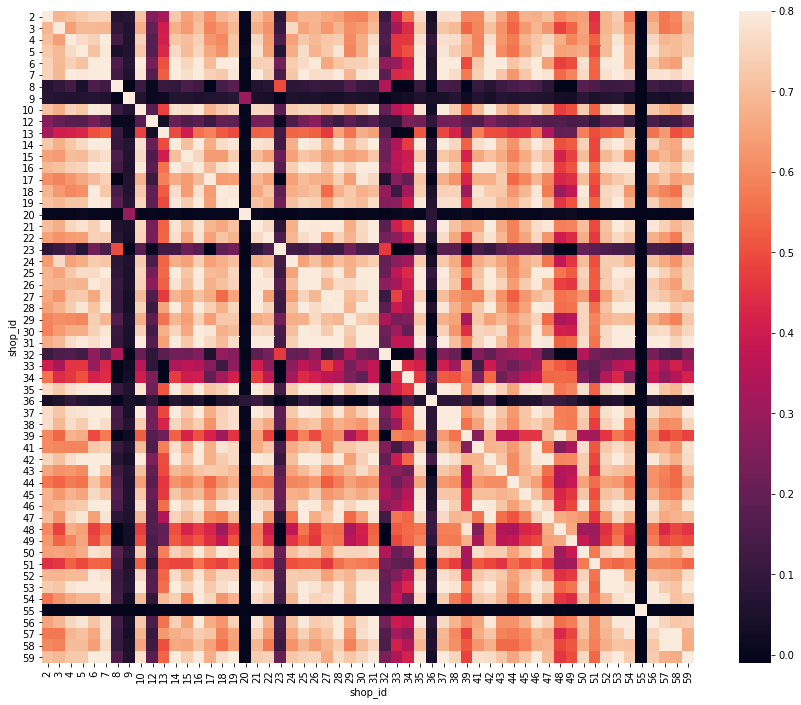

In [35]:
corrmat = shopwise_sales.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

>To get a good look in, we are going to have to squint a bit , but it's highly rewarding ~ in this one plot, we can examine the correlations between all given shops with each other in terms of their item sales!
>
>To start off, we see majority of the shops are light skin-peach-ish colours, indeed indicating a good correlation among shop sales.
>
>There are a few red/purple patches as well, but the worst of them all are the black ones. Let's turn our attention to these black shops, which indeed do seem likely to cast only darkness to our predictive models. If we squint hard enough, we can see there are 4 shops with those black lines - shops 9,20,36 and 55. Unfortunately shops 36 and 55 are present in our test set, so we are going to have to stick with those, however shops 9 and 20 seem to only bring noise in our train data set,let's see their shop names. 

In [38]:
print(sales.loc[(sales['shop_id']==9),'Trans_shops'].iloc[0])
print(sales.loc[(sales['shop_id']==20),'Trans_shops'].iloc[0])

Exit trade 
Moscow "Sale" 


>These seem to be some special "Sale" and "Exit" shops, that could explain why their transactions data is so unusual, and uncorrelated with the rest of the train data, let's get rid of these shops transactions data already. See I always say more data is not always better!... Ok thats a lie, I love data and I believe I can never have enough of it.
>
>Note: To be doubly sure, I did cross validation of my models both with and without these 2 shops as well, and no prizes for guessing, my models without these insolent shop data points fared way better. 

In [14]:
sales=sales[(sales['shop_id']!=9)&(sales['shop_id']!=20)]

>Now let us try to see if we can find some meaningful features from the shop names data. Something that immediately catches our eye, is the first word of all the shop names...most of them seem to belong to a city, we can definitely tell that about Moscow. Let us once again get our data in a more friendly format..

In [15]:
shopwise_sales=pd.DataFrame(sales.groupby(['date_block_num','Trans_shops','item_id'])['item_cnt_day'].sum()).reset_index()
shopwise_sales['month_item']=shopwise_sales['date_block_num'].astype('str')+'_'+shopwise_sales['item_id'].astype('str')
del shopwise_sales['date_block_num'],shopwise_sales['item_id']
shopwise_sales=shopwise_sales.set_index('month_item').pivot(columns='Trans_shops',values='item_cnt_day').fillna(0.0)
shopwise_sales['shop']=shopwise_sales.index.str.split('_')
shopwise_sales['shop']=shopwise_sales['shop'].str[1]
shopwise_sales.head()

Trans_shops,"! Yakutsk Ordzhonikidze, 56 fran","! Yakutsk shopping center ""Central"" Fran",1c-online digital warehouse,"Adygea shopping center ""Mega""","Balashiha TRK ""October-Kinomir""","Chekhov shopping center ""Carnival""","Himki Tc ""Mega""","Kaluga TPC ""XXI Century""","Kazan TC ""BEHETLE""","Kazan shopping center ""Parkhouse"" II",...,"Volzhsky shopping center ""Volga Mall""","Voronezh (Plekhanovskaya, 13)","Voronezh Trec ""Maximir""","Voronež TRC City Park ""Town""","Yakutsk Ordzhonikidze, 56","Yakutsk shopping center ""Central""","Yaroslavl shopping center ""Altair""",Zhukovsky st. Chkalova 39m?,Zhukovsky st. Chkalova 39m²,shop
month_item,,,,,,,,,,,,,,,,,,,,,
0_1000,5.0,3.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1000
0_10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000
0_10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10004
0_10008,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10008
0_1001,2.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1001


>From the above pivoted snapshot, we can easily see so many first names to be repeated among shop names, giving voice to my educated guess.
>
>I don't know about you readers, but I have little to no idea about the Russian geography, so once again to validate my guess, I am going to again dazzle and overwhelm our senses with a huge amount of data in a small space, so we better have our wits about to draw appropriate inferences!

C:\Users\PC\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



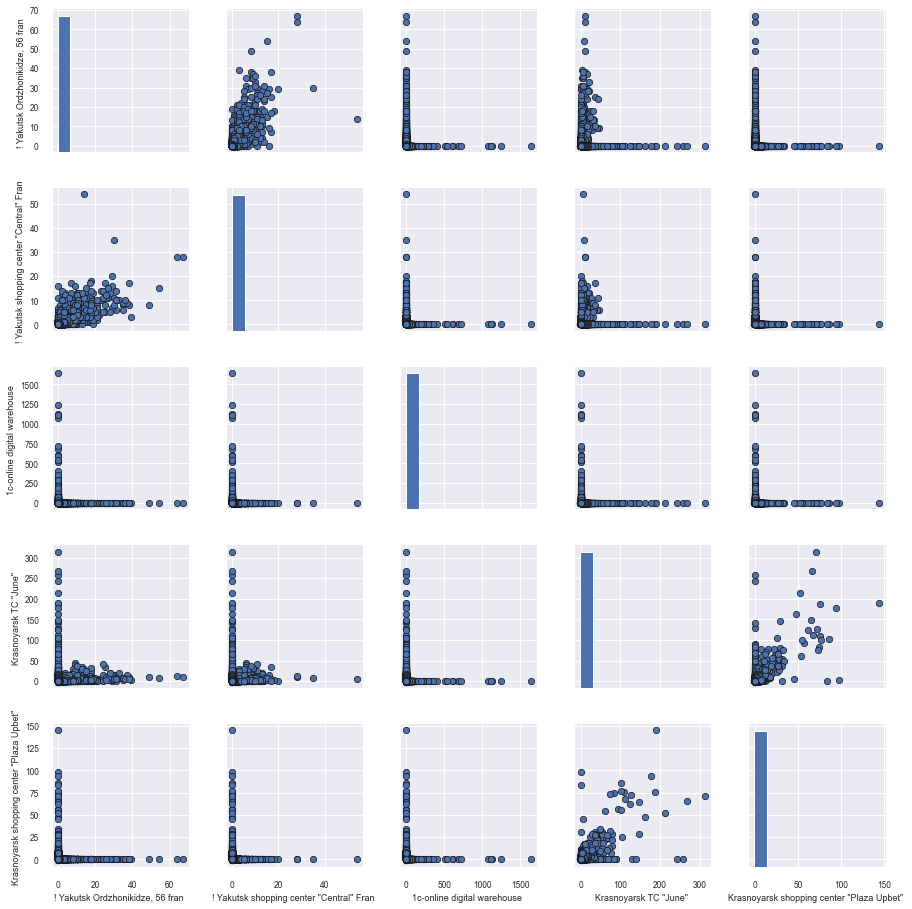

In [109]:
sns.set(font_scale = 0.75)
cols = shopwise_sales.columns[:3].tolist()+shopwise_sales.columns[11:13].tolist()
sns.pairplot(shopwise_sales[cols], size = 2.5, plot_kws= {"s":40,"alpha":1.0,'lw':0.5,'edgecolor':'k'})

plt.show();

>I have cherry picked 5 shops here, 4 of them belonging to the same cities in 2 pairs and 1 of them an online shop. Above I have the scatter plots of all these shops' sales data against one another, as we can see the plots confirm that there is indeed use for having a 'city' feature.
>
>As we see the Yakutsk city plots (first 2) and Krasnoyarsk city plots (last 2) are the only ones showing correlation in their scatter plots. The Yakutsk shops are uncorrelated with Krasnoyarsk shops and all the shops are uncorrelated with the online shop sales (middle row of plots) where we those L-shaped plots. The L-shaped plots are once again a reminder of how all the data is so skewed towards item sales of very small amounts. Thus we see a lot of promise for the 'city' feature which can so easily be formulated just as the first word of the shop names.

In [16]:
sales['city']=sales['Trans_shops'].str.split(' ').str[0]
sales['city'].unique()

array(['Yaroslavl', 'Moscow', 'Kursk', 'Krasnoyarsk', 'Volzhsky',
       'Voronezh', 'Adygea', 'Balashiha', '!', 'Kolo', 'Kaluga',
       'Voronež', 'Zhukovsky', 'Kazan', 'Online', 'Ufa', 'N.Novgorod',
       'Chekhov', 'Himki', 'Surgut', 'Tyumen', 'SPB', 'SPb',
       'Rostovnadon', 'Omsk', 'Samara', 'Novosibirsk', 'Sergiev',
       'Vologda', 'Yakutsk', '1c-online', 'Rostnone', 'Tomsk',
       'Mytishchi'], dtype=object)

>With the 'city' feature in hand, once again if we scrutinize all the city names (the devil is always in the details), we find that some cities are very similar with minute changes. This is because obviously we cannot rely on perfect translations from the Python Google library (that's right Google, you Suck!! Wait isn't Kaggle owned by Google now? Oh no.).
>
>For example, Voronez seems awfully similar to Voronezh and SPB to SPb, even though I have no clue where on Earth these cities are (I will remedy that as well in a bit). Also 'Online' to '1c=online', let's right these wrongs...

In [17]:
sales.loc[sales['city']=='Voronež','city']='Voronezh'
sales.loc[sales['city']=='SPb','city']='SPB'
sales['city']=np.where(sales['city'].str.contains('online'),'Internet',sales['city'])
sales['city']=np.where(sales['city'].str.contains('Online'),'Internet',sales['city'])
sales['city']=np.where(sales['city']=='Rostnone','Rostovnadon',sales['city'])

In [46]:
sales.loc[sales['city'].str.contains('Internet'),'shop_id'].unique()

array([12, 55], dtype=int64)

>Hmmm 12 and 55, why do they sound so familiar? Yes that's right if you scroll up to our correlation heatmaps, you will see 55 is another of those rogue black shops spreading darkness to our dataset, and 12 is pretty purple too. But since they are unfortunately present in our test set too, we have to stick with them and perhaps find another way to model them. Knowing that both of them belong to the category of Internet shops should help.
>
>Anyhow let's see what we can do about getting to those locations of these cities we have generated. I am a visual person and I like it when I am able to perfectly visualize what I am forecasting here.

In [20]:
geolocator = Nominatim(user_agent='myapplication')

# Get a basic world map.
shops_map = folium.Map(location=[60,40], zoom_start=3,tiles="Stamen Terrain")
for rus_city in sales['city'].unique():
    if rus_city=='Sergiev':
        rus_city= 'Sergiev Posad'
    location = geolocator.geocode(rus_city)
    if location!=None:
        folium.CircleMarker(location=[location.raw['lat'], location.raw['lon']], popup=rus_city,radius=2.5, 
                    color='yellow',
                    fill=True,
                    fill_color='blue',
                    fill_opacity=0.6).add_to(shops_map)
shops_map

>That is a satisfying imprint to visualize of all our shops. I think the shops in Austria ("Kolo") and France ("Ufa") are misrepresented here, so we can ignore them, but for the other cities, we can easily tell that even the cross-location distances, for eg. can be a great feature.
>
>That's a lot of food for thought from the shops data, let's now leap onto the items' data and direct our detective lens in that direction.

In [21]:
item=pd.read_csv("Inputs/items.csv")
item_cat=pd.read_csv("Inputs/item_categories.csv")
test=test.join(item.set_index('item_id'),on='item_id',how='left')
test=test.join(item_cat.set_index('item_category_id'),on='item_category_id',how='left')

sales=sales.join(item.set_index('item_id'),on='item_id',how='left')
sales=sales.join(item_cat.set_index('item_category_id'),on='item_category_id',how='left')

In [22]:
itemcat_sales=pd.DataFrame(sales.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].sum()).reset_index()
itemcat_sales['month_shop']=itemcat_sales['date_block_num'].astype('str')+'_'+itemcat_sales['shop_id'].astype('str')
del itemcat_sales['date_block_num'],itemcat_sales['shop_id']
itemcat_sales=itemcat_sales.set_index('month_shop').pivot(columns='item_category_id',values='item_cnt_day').fillna(0.0)
itemcat_sales.head()

item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
month_shop,,,,,,,,,,,,,,,,,,,,,
0_10,0.0,0.0,7.0,3.0,1.0,6.0,6.0,0.0,0.0,0.0,...,0.0,57.0,0.0,0.0,0.0,0.0,0.0,2.0,34.0,12.0
0_12,0.0,0.0,5.0,0.0,0.0,5.0,2.0,0.0,0.0,149.0,...,0.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0
0_14,0.0,0.0,21.0,5.0,1.0,9.0,10.0,0.0,0.0,0.0,...,0.0,24.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,30.0
0_15,0.0,0.0,30.0,7.0,4.0,9.0,22.0,0.0,0.0,0.0,...,0.0,142.0,0.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0


In [53]:
test['item_category_id'].nunique()

62

>Once again there are 84 item categories and not all of them are present in our test set (which has only 62 of them). So let us revisit our favorite heatmap once again, this time looking at the item categories' sales data pitted against each other.

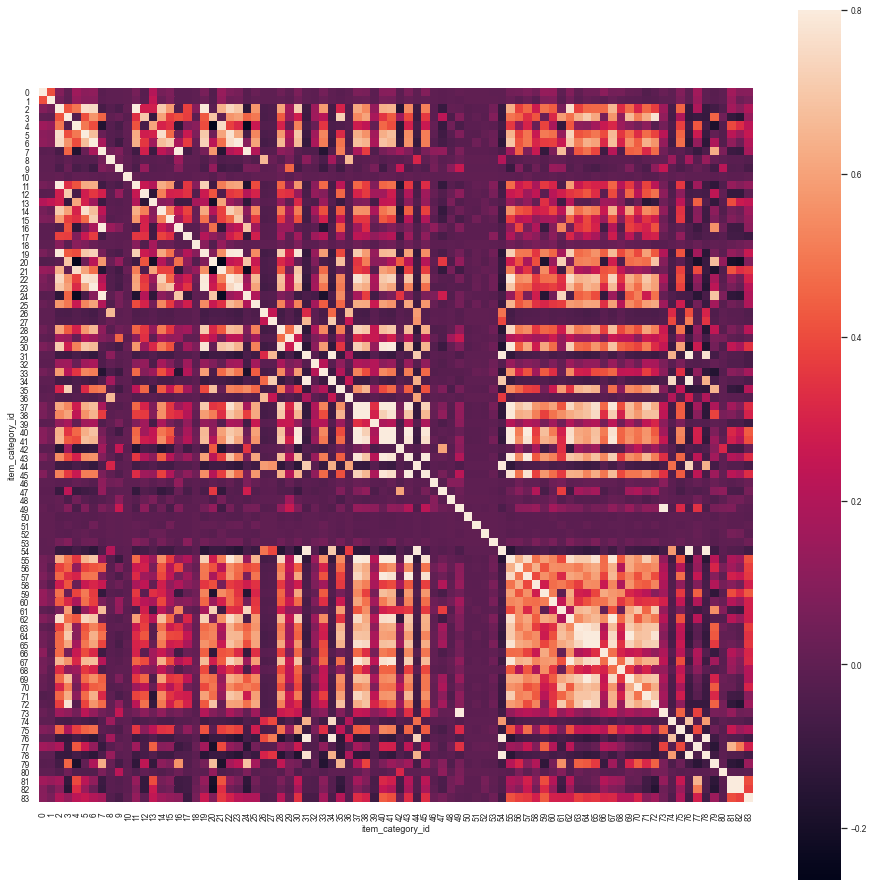

In [54]:
corrmat = itemcat_sales.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, square=True);

>Oh my those purple corridors, I think even a truck could pass through them! The item categories' sales data seems much more uncorrelated in general with each other as opposed to that of shops, which intuitively makes a lot of sense. I mean how much can the same product be different in price and amount of sales among different shops really? Maybe some really entreprenuerial shop salesmen can do better than others, but for the same product, it cannot be that much different.
>
>Whereas if we talk about different item categories in the same shop, they could be as different as an 'Apple Iphone' and a Ps4 DvD for Witcher 3. One of these rightfully charges a small fortune whereas the other forces it's customers to sell a kidney (and a lung for it's accessories) to pay out a huge fortune (no I'm not going to specify which is which). And thus I really don't see a strong reason to hold on to the item categories' data for which there is no mention of in the test set. And yes once again I did cross validate my models with and without these 22 item categories, finding not a major difference in forecasting accuracy but definitely a boost in forecasting time.

In [23]:
sales=sales.loc[sales['item_category_id'].isin(test['item_category_id'])]

>Now let's translate all our item category names too, so we can make some sense out of those.

In [24]:
translator = google_translator()

cat_translations = {}
unique_elements = item_cat['item_category_name'].unique()
for element in unique_elements:
    # add translation to the dictionary
    cat_translations[element] = translator.translate(element)
    
item_cat['Trans_cat']=item_cat['item_category_name'].map(cat_translations)
sales['Trans_cats']=sales['item_category_name'].map(cat_translations)

In [57]:
sales['Trans_cats'].unique()

array(['Movie - Blu-Ray ', 'Music - Vinyl ',
       'Music - corporate production CD ', 'Music - Local CD CD ',
       'Games - Xbox 360 ', 'Games - PS3. ',
       'PC Games - Additional Editions ', 'PC Games - Standard Editions ',
       'Games - PSP. ', 'Cinema - DVD. ',
       'Programs - for home and office ',
       'Books - Methodological materials 1C ',
       'PC Games - Collectible Editions ', 'Games - psvita. ',
       'Gifts - development ', 'Programs - 1C: Enterprise 8 ',
       'Programs - Educational ', 'Music - mp3 ',
       'Music - Gift Editions ', 'Gifts - Gadgets, Robots, Sports ',
       'Books - audiobooks ', 'Gaming Consoles - Xbox 360 ',
       'Accessories - PS3 ', 'Accessories - PS4. ',
       'Accessories - Psvita. ', 'Payment cards - PSN ',
       'Payment cards - Live! ', 'Accessories - Xbox 360 ',
       'Cinema - Blu-ray 3D ', 'Games - Accessories for games ',
       'Books - Audiobooks 1C ', 'Cinema - collectivity ',
       'Gaming Consoles - PS3 ', 'Gift

>I see a lot of similar categories, for eg the various 'Games' categories and obviously they are not the same but they can be expected to exhibit similar behaviour in terms of item sales and Revenue. Thus providing the potential to create a new feature which would perhaps be a broader category clubbing these similar categories together. Let's hold that thought in our minds for a little bit, I will get to it in just a minute. But first let's also translate the item names so it can easily be worked on. Note that I am not going to run the item names translations here because it took me ages to run that on my Personal PC. I will just load it here.

In [25]:
item_translates=pd.read_csv("Inputs/Completed_item_translations.csv")
item_translates.columns=['item_name','Trans_item']
item_translates=dict(item_translates.values)
sales['Trans_item']=sales['item_name'].map(item_translates)

item_cat_best=sales.groupby(['Trans_cats','Trans_item'])['item_cnt_day'].sum().sort_values(ascending=False).reset_index()
item_cat_best[:10]

,Trans_cats,Trans_item,item_cnt_day
0,"Gifts - Bags, Albums, Rugs D / Mouse",Brand Package Mike 1C Interest White (34 * 42)...,186642.0
1,PC Games - Standard Editions,"Diablo III [PC, Jewel, Russian version]",17156.0
2,Games - PS3.,"Grand Theft AUTO V [PS3, Russian subtitles]",16518.0
3,Service,Reception of funds for 1C-online,15816.0
4,Payment cards - PSN,PlayStation Store Wallet Replenishment: Paymen...,14502.0
5,Games - Xbox 360,"Grand Theft AUTO V [Xbox 360, Russian subtitles]",11550.0
6,Gaming Consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,10276.0
7,PC Games - Standard Editions,"Grand Theft Auto V [PC, Russian subtitles]",10099.0
8,PC Games - Standard Editions,"Battlefield 4 [PC, Russian version]",9969.0
9,Games - PS3.,"Some of us [PS3, Russian version]",9182.0


>Armed with the translations of both categories and items now, let's get a bit inventive with how we visualize the top categories and items, and move away from the Seaborn sensation for a little bit.

In [27]:
import plotly.express as px
fig =px.sunburst(
    item_cat_best[1:11],path=['Trans_cats','Trans_item'],
    values='item_cnt_day',title='Top 10 Item Category/Item name Pairs Sunburst'
)
fig.show()

>Wow another unbelieveable method of summarising such a great deal of information in just a circle, I was truly infatuated when I came across this idea of visualizing the various categories as several rings of the circle, starting with the top 10 broader 'item categories' feature here, and on the outer half presenting the top items within each of these categories, and if we hover over any of them, we can even see the exact item sales values for each grouping.
>
>This Sunburst once again reiterates my earlier point of having similar categories, as we can see from the 3 'Games' categories in the various platforms: PC,PS3 and Xbox 360. All 3 of these 'Games' categories have 'Grand Theft Auto' as their top grossing product and these games can be expected to exhibit similar characteristics, so let's create a grouping for these similar categories and similar items.

In [28]:
sales['Broad_cat']=sales['Trans_cats'].str.split('-').str[0]
sales.loc[sales['Broad_cat']=='PC games ','Broad_cat']='PC Games '
sales['Broad_cat'].unique()

array(['Movie ', 'Music ', 'Games ', 'PC Games ', 'Cinema ', 'Programs ',
       'Books ', 'Gifts ', 'Gaming Consoles ', 'Accessories ',
       'Payment cards ', 'Service ', 'PC ', 'Power elements ',
       'Delivery of goods ', 'Android games ', 'MAC games ',
       'Payment maps '], dtype=object)

>There that's lesser than a quarter of the categories we started out with and it looks a lot more cleaner too. I have actually left categories like PC Games, Games, Android Games etc. separated here, but another very interesting paradigm to consider is to club all such categories together (the aforementioned categories could all be grouped under 'Games'), and make an additional feature of the platform the item belongs to (very relevant since this is a software retail company's data we are playing with).

In [29]:
sales['Broad_item']=sales['Trans_item'].str.split(' ').str[0:2].str.join(',').str.replace(',',' ')
sales['Broad_item'].head()

0    Phenomenon 2012
1        DEEP PURPLE
2        DEEP PURPLE
3        DEEP PURPLE
4        DEEP PURPLE
Name: Broad_item, dtype: object

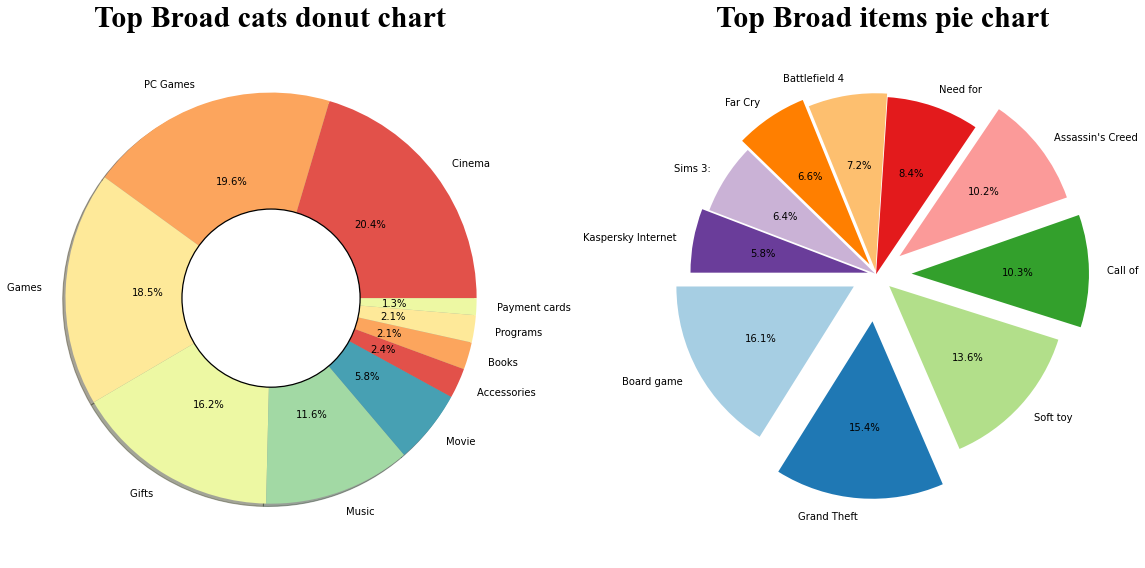

In [30]:
fig = plt.subplots(figsize=(16, 8))

plt.subplot(121)
custom_colors = sns.color_palette("Spectral")
broadcat_sales=sales.groupby('Broad_cat')['item_cnt_day'].sum().sort_values(ascending=False).reset_index()[:10]
plt.pie(broadcat_sales['item_cnt_day'],labels=broadcat_sales['Broad_cat'],radius = 1.5,\
        explode=(0,0,0,0,0,0,0,0,0,0),autopct='%1.1f%%',colors=custom_colors,shadow=True)
centre_circle = plt.Circle((0,0),0.65,color='black', fc='white',linewidth=1.25)
plt.title("Top Broad cats donut chart",fontsize= 30,fontname="Times New Roman",fontweight="bold")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
fig.tight_layout()

plt.subplot(122)
import matplotlib.colors as colors
custom_colors = sns.color_palette("Paired")
broaditem_sales=sales.groupby('Broad_item')['item_cnt_day'].sum().sort_values(ascending=False).reset_index()[1:11]
plt.pie(broaditem_sales['item_cnt_day'],labels=broaditem_sales['Broad_item'],radius = 1.5,\
        explode=(0.215,0.4,0.15,0.3,0.25,0,0.03,0.1,0.01,0.07),autopct='%1.1f%%',colors=custom_colors,startangle=180)
plt.title("Top Broad items pie chart",fontsize= 30,fontname="Times New Roman",fontweight="bold")
plt.axis('equal')
fig.tight_layout()
plt.show()

>For all you enthusiastic foodies, isn't it so awesome that we can fix our appetite with these data appetizers, served as donuts and pies, I think I am already drooling. Making Broad Item categories has helped us to easily see the most selling items. For instance the games are obviously the biggest sales for 1C, here we see the games just have the first 2 words of their name (making some of them weird but still uniquely identifiable - for all you gamers, "Need for" is obviously NFS (Need For Speed), "Call of " is obviously "Call of Duty"); a fact that would be harder to prove just by seeing the pie charts on individual items, since that would be spread across various platforms.
>
>Let's now move across to unsheath another of our big weapons from our data armoury and perform some text analysis.

In [32]:
items_subset = item[['item_id', 'item_name','item_category_id','Trans_item']]

feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
tfidf = TfidfVectorizer()
items_text_fts = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

cols =items_text_fts.columns
for i in range(feature_count):
    feature_name = 'item_name_tfidf_' + str(i)
    items_subset[feature_name] = items_text_fts[cols[i]]

<ipython-input-32-4324f6f50c36>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
items_text_fts.shape

(22170, 18222)

In [71]:
!pip install umap-learn

  Using cached umap_learn-0.5.1-py3-none-any.whl
  Using cached pynndescent-0.5.4-py3-none-any.whl
  Using cached numba-0.53.1-cp38-cp38-win_amd64.whl (2.3 MB)
  Using cached numba-0.53.0-cp38-cp38-win_amd64.whl (2.3 MB)
  Using cached numba-0.52.0-cp38-cp38-win_amd64.whl (2.3 MB)
  Using cached numba-0.51.2-cp38-cp38-win_amd64.whl (2.2 MB)
INFO: pip is looking at multiple versions of joblib to determine which version is compatible with other requirements. This could take a while.
  Using cached joblib-1.0.0-py3-none-any.whl (302 kB)
  Using cached joblib-0.17.0-py3-none-any.whl (301 kB)
  Using cached joblib-0.16.0-py3-none-any.whl (300 kB)
  Using cached joblib-0.15.1-py3-none-any.whl (298 kB)
  Using cached joblib-0.15.0-py3-none-any.whl (298 kB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Using cached joblib-0.14.0-py2.py3-none-any.whl (294 kB)
  Using cached joblib-0.13.2-py2.py3-none-any.whl (278 kB)
  Using cached joblib-0.13.1-py2.py3-none-any.whl (278 kB)
  Us

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


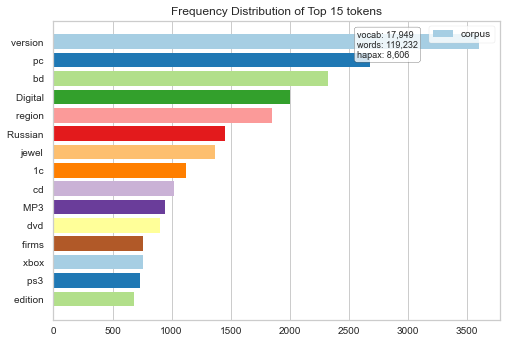

In [35]:
vectorizer = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(stopwords.words('russian')))
docs = vectorizer.fit_transform(items_subset['item_name'])

word_list = vectorizer.get_feature_names()
count_list = docs.toarray().sum(axis=0)
vals=dict(zip(word_list, count_list))

N = 15
res = dict(sorted(vals.items(), key = itemgetter(1), reverse = True)[:N])

features = vectorizer.get_feature_names()

new_vals=[]
rus_vals=[]
for element in res.keys():
    rus_vals.append(element)
    new_vals.append(translator.translate(element))

for n, i in enumerate(features):
    for count in range(N):
        if i==rus_vals[count]:
            features[n]=new_vals[count]   
            
visualizer = FreqDistVisualizer(features=features,n=N,color=custom_colors)
visualizer.fit(docs)
visualizer.poof()

>Starting out with a simple CountVectorizer, I had to be sure to do the count on Russian words itself (translation always loses some value), remove the stop words of both the English and Russian dictionaries and then convert the words back to English for us; finally thanks to YellowBrick, we have it neatly plotted into a Frequency Distribution visualizer. Once again we see how useful a platform feature will be for our prediction here (will generate it in 2nd kernel), with most keywords playing around pc,ps3,xbox and even MP3!
>
>Let's now move across to generating features from the item names text (I found the item names to be the most useful text feature for deriving robust predictive features) using TfIdf Vectorizer from Sklearn. To visualize it, I am going to discretize item sales too.

In [106]:
sample_sales=sales.loc[sales['item_cnt_day']<=1.0].iloc[:500]
sample_sales=sample_sales.append(sales.loc[(sales['item_cnt_day']>20.0)&(sales['item_cnt_day']<30.0)].iloc[:500])
sample_sales=sample_sales.append(sales.loc[sales['item_cnt_day']>45.0].iloc[:500])
sample_sales['binned_item_cnt']=pd.qcut(sample_sales['item_cnt_day'].rank(method='first'),q=3)
sample_sales['binned_item_cnt'].unique()

[(0.999, 500.667], (500.667, 1000.333], (1000.333, 1500.0]]
Categories (3, interval[float64]): [(0.999, 500.667] < (500.667, 1000.333] < (1000.333, 1500.0]]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


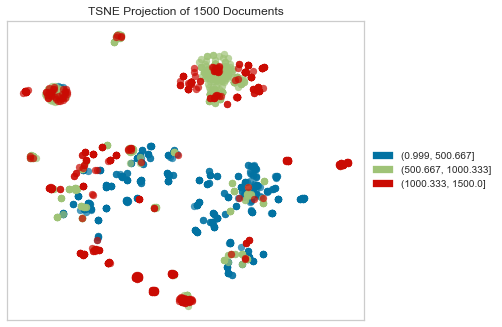

In [108]:
tsne = TSNEVisualizer()

tsne.fit(tfidf.fit_transform(sample_sales['item_name']),sample_sales['binned_item_cnt'],color=sns.color_palette("Spectral"),\
cmap = ListedColormap(('red', 'green')))
tsne.poof()

>The binning of the item sales meant that I was able to plot the text features such that we can see whether these features were able to divvy up the binned vector into clusters. But since item sales were heavily right skewed, I had to individually pick a set of sample transactions to ensure there was sufficient dispersion among them while plotting TSNE graph. And we can see some blobs of the 3 colours being formed, providing evidence of the efficacy for using item text features.
>
>Finally let us move to a very interesting observation I made with the help of another timeseries plot which can be described as how 1C has grown it's items and shops base with time, which assisted me a great deal in doing some post-processing for improving my model forecasts.

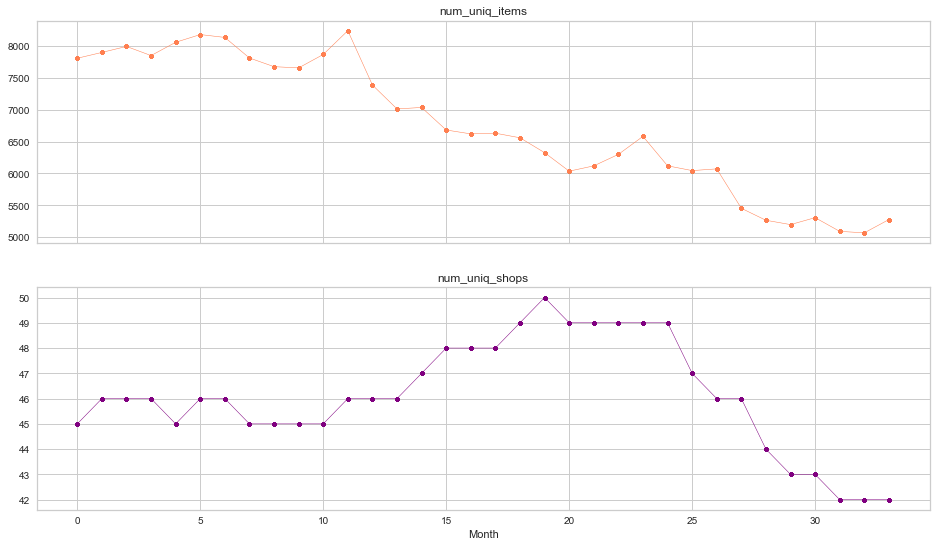

In [122]:
sales['num_uniq_items']=sales.groupby('date_block_num')['item_id'].transform(lambda x: x.nunique())
sales['num_uniq_shops']=sales.groupby('date_block_num')['shop_id'].transform(lambda x: x.nunique())

fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
colors={'num_uniq_items':'coral','num_uniq_shops':'purple'}

for name, ax in zip(['num_uniq_items','num_uniq_shops'], axes):
    ax.plot(sales.set_index('date_block_num')[name], marker='.', linestyle='-', linewidth = 0.5, label=name, color=colors[name])
    #sns.boxplot(data = sales, x='date_block_num', y=name, ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("Month")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

>The above timeseries plots are great to demonstrate how 1C shops' sales have developed over time (given the data we have). We see a clear decrease in both the number of item offerings and operating shops for 1C; this raises a very important question, namely how many items are in test set that could be such that they are now outdated,i.e have not been sold by any of the shops since past few months? Let us do some analysis to find out, once again in my favorite dataframe format, the pivoted tables.

In [125]:
pivoted_item_sales = sales.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
pivoted_item_sales.columns = pivoted_item_sales.columns.droplevel().map(str)
pivoted_item_sales = pivoted_item_sales.reset_index(drop=True).rename_axis(None, axis=1)
pivoted_item_sales.columns.values[0] = 'item_id'

outdated_items = pivoted_item_sales[pivoted_item_sales.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items: 11684
Outdated items in test set: 6972



>The implication of the above finding is extremely significant! It means that there is a very strong chance those 6972 items in test set (across all shops) are likely to have zero sales for our test month (November), we can simply mark them as 0.0 for our predictions without even running any models! I cross validated the use of this logic for prior months, the most shocking fact I found is even the best models I could train did not make the zero predictions, which when I manually changed to zero, improved my cross validation error significantly. This just goes to show how important preprocessing,visualization,EDA and in general human intuition is, given that it can beat even the most complex models in existence (at least so far it can).
>
>And I think that is a very fitting note to end the 1st part of my kernels in, it's truly been extremely fun and joyous putting this together, and I have learned so much while attempting to articulately express my thought process with my work on this competition. I hope you readers have gained at least a little as well from the journey, if not then read it again! Jokes aside, thanks so much for taking the time to read my notebook, so <b>please do drop feedback on how I can improve it, and what you did/did not like</b>.